# Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import RiskLabAI.data.denoise.denoising as dn

# Include py file

# TESTING THE MARCENKO–PASTUR THEOREM

In [2]:
x = np.random.normal(size=(10000, 1000))
eval0, _ = dn.pca(np.corrcoef(x, rowvar=False))
pdf0 = dn.marcenko_pastur_pdf(1., q=x.shape[0] / float(x.shape[1]), num_points=1000)
pdf1 = dn.fit_kde(np.diag(eval0), bandwidth=.01)

In [3]:
var = 1
q = x.shape[0] / float(x.shape[1])
pts = 1000
emin, emax = var * (1 - (1. / q) ** .5) ** 2, var * (1 + (1. / q) ** .5) ** 2
_eval = np.linspace(emin, emax, pts)

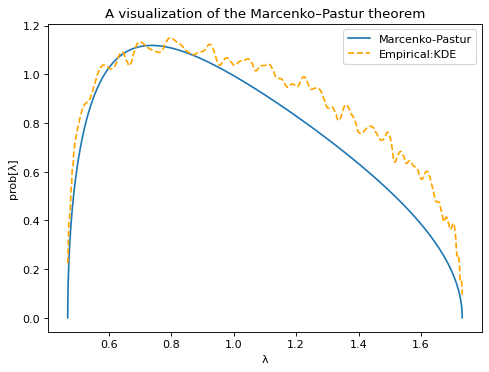

In [4]:
plt.figure(figsize=(7, 5), dpi=80)
plt.plot(_eval, pdf0)
plt.title("A visualization of the Marcenko–Pastur theorem")
plt.xlabel("λ")
plt.ylabel("prob[λ]")
plt.plot(_eval, pdf1, color='orange', ls='dashed')
legend_drawn_flag = True
plt.legend(["Marcenko-Pastur", "Empirical:KDE"], loc=0, frameon=legend_drawn_flag)
plt.show()

# ADD SIGNAL TO A RANDOM COVARIANCE MATRIX

In [5]:
alpha, ncols, nfact, q = .995, 1000, 100, 10
cov = np.cov(np.random.normal(size=(ncols * q, ncols)), rowvar=False)
cov = alpha * cov + (1 - alpha) * dn.random_cov(ncols, nfact)  # noise+signal
corr0 = dn.cov_to_corr(cov)
eval0, evec0 = dn.pca(corr0)

# FITTING THE MARCENKO–PASTUR PDF

In [6]:
emax0, var0 = dn.find_max_eval(np.diag(eval0), q, bandwidth=.01)
nfacts0 = eval0.shape[0] - np.diag(eval0)[::-1].searchsorted(emax0)

In [7]:
nfacts0

100

In [8]:
var0

0.6792673903891628

# Denoising

## Constant Residual Eigenvalue Method

In [9]:
corr1 = dn.denoised_corr(eval0, evec0, nfacts0)
eval1, evec1 = dn.pca(corr1)

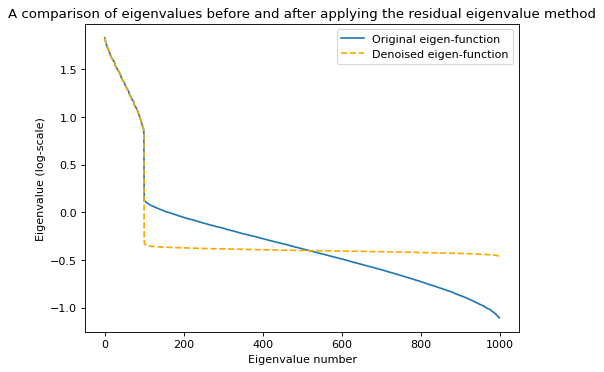

In [10]:
plt.figure(figsize=(7, 5), dpi=80)
plt.plot(np.log(np.diag(eval0)))
plt.title("A comparison of eigenvalues before and after applying the residual eigenvalue method")
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue (log-scale)")
plt.plot(np.log(np.diag(eval1)), color='orange', ls='dashed')
legend_drawn_flag = True
plt.legend(["Original eigen-function", "Denoised eigen-function"], loc=0, frameon=legend_drawn_flag)
plt.show()

# Detoning

# DENOISING BY TARGETED SHRINKAG

In [11]:
corr1 = dn.denoised_corr2(eval0, evec0, nfacts0, alpha=.5)
eval1, _ = dn.pca(corr1)

# GENERATING A BLOCK-DIAGONAL COVARIANCE MATRIX AND A VECTOR OF MEANS

In [12]:
nblocks, bsize, bcorr = 10, 50, .5
np.random.seed(0)
mu0, cov0 = dn.form_true_matrix(nblocks, bsize, bcorr)

# DENOISING OF THE EMPIRICAL COVARIANCE MATRIX

 # Minimum Variance Portfolio

In [13]:
nObs, ntrials, bwidth, shrink, min_var_portf = 100, 100, .01, False, True
w1 = pd.DataFrame(columns=range(cov0.shape[0]), index=range(ntrials), dtype=float)
w1_d = w1.copy(deep=True)
np.random.seed(0)
for i in range(ntrials):
    mu1, cov1 = dn.simulates_cov_mu(mu0, cov0, nObs, shrink=shrink)
    if min_var_portf:
        mu1 = None
    cov1_d = dn.denoise_cov(cov1, nObs * 1. / cov1.shape[1], bwidth)
    w1.loc[i] = dn.optimal_portfolio(cov1, mu1).flatten()
    w1_d.loc[i] = dn.optimal_portfolio(cov1_d, mu1).flatten()

# ROOT-MEAN-SQUARE ERRORS

In [14]:
w0 = dn.optimal_portfolio(cov0, None if min_var_portf else mu0)
w0 = np.repeat(w0.T, w1.shape[0], axis=0)
rmsd = np.mean((w1 - w0).values.flatten() ** 2) ** .5  # RMSE
rmsd_d = np.mean((w1_d - w0).values.flatten() ** 2) ** .5  # RMSE
print(rmsd, rmsd_d)

0.5622182073108648 0.004744439435197061
